The date is December 21st
This notebook is meant to show that erf can be linearized

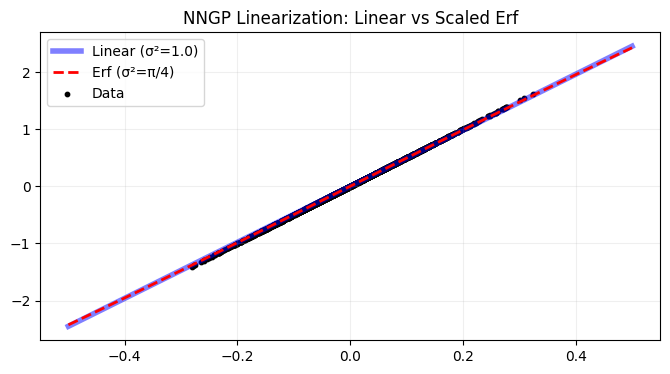

Mean Difference: 7.16e-05


In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def solve_gp(K_train, K_test, y_train, ridge=0.04):
    """Standard GPR inference: K_xt @ (K_tt + noise)^-1 @ y"""
    L = torch.linalg.cholesky(K_train + ridge * torch.eye(K_train.shape[0]))
    alpha = torch.cholesky_solve(y_train, L)
    return K_test @ alpha

# 1. Setup Data (Small inputs to stay in the linear regime of Erf)
d, P = 10, 2000
X_train = torch.randn(P, d) * 0.1  # Small scale inputs
X_test_axis = torch.linspace(-0.5, 0.5, 100)
X_test = torch.zeros(100, d)
X_test[:, 0] = X_test_axis
Y_train = X_train[:, 0:1] * 5.0    # Linear ground truth

# 2. Define Kernels
def get_linear_K(X1, X2, sigma_w2=1.0):
    return sigma_w2 * (X1 @ X2.T) / d

def get_erf_K(X1, X2, sigma_w2=0.7853): # pi/4
    # Compute Sigma matrix
    Sigma_12 = sigma_w2 * (X1 @ X2.T) / d
    Sigma_11 = sigma_w2 * torch.sum(X1**2, dim=1) / d
    Sigma_22 = sigma_w2 * torch.sum(X2**2, dim=1) / d
    # Arcsin argument denom: sqrt((1 + 2*var1)(1 + 2*var2))
    denom = torch.sqrt((1 + 2 * Sigma_11[:, None]) * (1 + 2 * Sigma_22[None, :]))
    arg = torch.clamp(2 * Sigma_12 / denom, -1.0, 1.0)
    return (2 / np.pi) * torch.asin(arg)

# 3. Compute Predictions
# Linear Network with sigma_w2 = 1.0
K_lin_tt = get_linear_K(X_train, X_train, 1.0)
K_lin_xt = get_linear_K(X_test, X_train, 1.0)
y_lin = solve_gp(K_lin_tt, K_lin_xt, Y_train)

# Erf Network with sigma_w2 = pi/4
K_erf_tt = get_erf_K(X_train, X_train, sigma_w2 =np.pi/4)
K_erf_xt = get_erf_K(X_test, X_train, sigma_w2 = np.pi/4)
y_erf =  solve_gp(K_erf_tt, K_erf_xt, Y_train)

# 4. Plot
plt.figure(figsize=(8, 4))
plt.plot(X_test_axis, y_lin, label="Linear (σ²=1.0)", color="blue", lw=4, alpha=0.5)
plt.plot(X_test_axis, y_erf, label="Erf (σ²=π/4)", color="red", ls="--", lw=2)
plt.scatter(X_train[:, 0], Y_train, color='black', label="Data", s=10)
plt.title("NNGP Linearization: Linear vs Scaled Erf")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# Print the Mean Squared Difference
print(f"Mean Difference: {torch.mean((y_lin - y_erf)**2).item():.2e}")

# Rescaling the Erf and Linear Networks

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import numpy as np

# --- 1. Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
D_IN, P, N = 5, 64, 256
LR, T_EFF = 1e-4, 0.12  # Simplified T_EFF = 2 * kappa / chi
EPOCHS = 100000 

# Rescaling factor for Erf to match Linear TrSigma
SIGMA2_ERF = (3 * np.pi) / 4
SIGMA2_LIN = 1.0

# --- 2. Data & Modules ---
torch.manual_seed(42)
X = torch.randn(P, D_IN, device=DEVICE) / math.sqrt(D_IN)
Y = X[:, 0:1]

class SGLDNetwork(nn.Module):
    def __init__(self, d, n, sigma_w2, activation="erf"):
        super().__init__()
        self.activation, self.sigma_w2, self.d, self.n = activation, sigma_w2, d, n
        self.W = nn.Parameter(torch.randn(n, d, device=DEVICE) * math.sqrt(sigma_w2 / d))
        self.V = nn.Parameter(torch.randn(1, n, device=DEVICE) * math.sqrt(1.0 / n))

    def forward(self, x):
        h = x @ self.W.T
        return (torch.erf(h) if self.activation == "erf" else h) @ self.V.T

    def get_kernel_eigenvalues(self, x):
        with torch.no_grad():
            h = x @ self.W.T
            phi = torch.erf(h) if self.activation == "erf" else h
            K = (phi @ phi.T) / self.n
            return torch.linalg.eigvalsh(K).cpu().numpy()

def train(model, epochs):
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    # Weight decay: lambda = T_eff / sigma^2
    wd_w = T_EFF / model.sigma_w2 / model.d
    wd_v = T_EFF / 1.0 / model.n
    noise_std = math.sqrt(2 * LR * T_EFF)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = torch.sum((model(X) - Y)**2)
        loss.backward()
        with torch.no_grad():
            for p, wd in zip([model.W, model.V], [wd_w, wd_v]):
                p.data.add_(p.grad + wd * p.data, alpha=-LR)
                p.data.add_(torch.randn_like(p) * noise_std)
    return model.get_kernel_eigenvalues(X)



In [11]:

# --- 3. Execution & Comparison ---
results = {
    "Linear ($\sigma^2=1.0$)": train(SGLDNetwork(D_IN, N, SIGMA2_LIN, "linear"), EPOCHS),
    "Erf Rescaled ($\sigma^2=3\pi/4$)": train(SGLDNetwork(D_IN, N, SIGMA2_ERF, "erf"), EPOCHS) * 3 * np.pi / 4,
    "Erf Unscaled ($\sigma^2=1.0$)": train(SGLDNetwork(D_IN, N, SIGMA2_LIN, "erf"), EPOCHS)
}


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2901596/1454192609.py:3: SyntaxWarning: invalid escape sequence '\s'
  "Linear ($\sigma^2=1.0$)": train(SGLDNetwork(D_IN, N, SIGMA2_LIN, "linear"), EPOCHS),
/tmp/ipykernel_2901596/1454192609.py:4: SyntaxWarning: invalid escape sequence '\s'
  "Erf Rescaled ($\sigma^2=3\pi/4$)": train(SGLDNetwork(D_IN, N, SIGMA2_ERF, "erf"), EPOCHS) * 3 * np.pi / 4,
/tmp/ipykernel_2901596/1454192609.py:5: SyntaxWarning: invalid escape sequence '\s'
  "Erf Unscaled ($\sigma^2=1.0$)": train(SGLDNetwork(D_IN, N, SIGMA2_LIN, "erf"), EPOCHS)


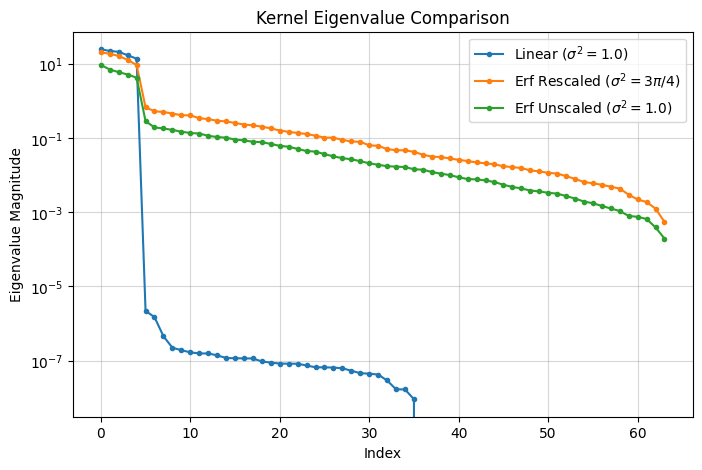

In [13]:

# --- 4. Plotting ---
plt.figure(figsize=(8, 5))
for label, evals in results.items():
    plt.plot(np.sort(evals)[::-1][:], label=label, marker='o', markersize=3)

plt.title("Kernel Eigenvalue Comparison")
plt.ylabel("Eigenvalue Magnitude")
plt.xlabel("Index")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()